In [1]:
"""
Please run notebook locally (if you have all the dependencies and a GPU). 
Technically you can run this notebook on Google Colab but you need to set up microphone for Colab.
 
Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
5. Set up microphone for Colab
"""
# If you're using Google Colab and not running locally, run this cell.

## Install dependencies
!pip install wget
!apt-get install sox libsndfile1 ffmpeg portaudio19-dev
!pip install unidecode
!pip install pyaudio

# ## Install NeMo
!python -m pip install --upgrade git+https://github.com/NVIDIA/NeMo.git#egg=nemo_toolkit[asr]

## Install TorchAudio
!pip install torchaudio>=0.6.0 -f https://download.pytorch.org/whl/torch_stable.html

Reading package lists... Done
Building dependency tree       
Reading state information... Done
portaudio19-dev is already the newest version (19.6.0-1).
libsndfile1 is already the newest version (1.0.28-4ubuntu0.18.04.1).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
sox is already the newest version (14.4.2-3ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
  Cloning https://github.com/NVIDIA/NeMo.git to /tmp/pip-install-p1c6f4l7/nemo-toolkit
  Running command git clone -q https://github.com/NVIDIA/NeMo.git /tmp/pip-install-p1c6f4l7/nemo-toolkit


  Created wheel for nemo-toolkit: filename=nemo_toolkit-1.0.0b1-py3-none-any.whl size=411726 sha256=bd0299142bdf0606cfc9981907ee109462e53c25ad184706d899c2423dde214c
  Stored in directory: /tmp/pip-ephem-wheel-cache-e7dz7djm/wheels/ab/b2/f1/d7b286852fec994ee0cf0a1e43c728795adddc73ba19914f8e
Successfully built nemo-toolkit
  Attempting uninstall: nemo-toolkit
    Found existing installation: nemo-toolkit 1.0.0b1
    Uninstalling nemo-toolkit-1.0.0b1:
      Successfully uninstalled nemo-toolkit-1.0.0b1


This notebook demonstrates VAD (Voice Activity Detection) from a microphone's stream in NeMo.

It is **not a recommended** way to do inference in production workflows. If you are interested in 
production-level inference using NeMo ASR models, please sign-up to Jarvis early access program: https://developer.nvidia.com/nvidia-jarvis

The notebook requires PyAudio library to get a signal from an audio device.
For Ubuntu, please run the following commands to install it:
```
sudo apt-get install -y portaudio19-dev
pip install pyaudio
```

This notebook requires the `torchaudio` library to be installed for MatchboxNet. Please follow the instructions available at the [torchaudio Github page](https://github.com/pytorch/audio#installation) to install the appropriate version of torchaudio.

If you would like to install the latest version, please run the following command to install it:

```
conda install -c pytorch torchaudio
```

In [2]:
import numpy as np
import pyaudio as pa
import os, time
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline

import nemo
import nemo.collections.asr as nemo_asr

[NeMo W 2020-10-01 08:47:06 experimental:28] Module nemo.collections.asr.data.audio_to_text.AudioToCharDataset is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-01 08:47:06 experimental:28] Module nemo.collections.asr.data.audio_to_text.AudioToBPEDataset is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-01 08:47:06 experimental:28] Module nemo.collections.asr.data.audio_to_text.AudioLabelDataset is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-01 08:47:06 experimental:28] Module nemo.collections.asr.data.audio_to_text.TarredAudioToTextDataset is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-01 08:47:06 experimental:28] Module nemo.collections.asr.data.audio_to_text.TarredAudioToCharDataset is experimental, not ready for production and is not fully supporte

In [3]:
# sample rate, Hz
SAMPLE_RATE = 16000

## Restore the model from NGC

In [4]:
vad_model = nemo_asr.models.EncDecClassificationModel.from_pretrained('MatchboxNet-VAD-3x2')

[NeMo I 2020-10-01 08:47:07 cloud:55] Found existing object /root/.cache/torch/NeMo/NeMo_1.0.0b1/MatchboxNet_VAD_3x2/1375f3813383105a24acc75428ec51c4/MatchboxNet_VAD_3x2.nemo.
[NeMo I 2020-10-01 08:47:07 cloud:61] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.0.0b1/MatchboxNet_VAD_3x2/1375f3813383105a24acc75428ec51c4/MatchboxNet_VAD_3x2.nemo
[NeMo I 2020-10-01 08:47:07 common:395] Instantiating model from pre-trained checkpoint


[NeMo W 2020-10-01 08:47:07 modelPT:102] Please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /home/fjia/code/manifest64/balanced_background_training_manifest.json,/home/fjia/code/manifest64/balanced_speech_training_manifest.json
    sample_rate: 16000
    labels:
    - background
    - speech
    batch_size: 128
    num_workers: 20
    shuffle: true
    augmentor:
      shift:
        prob: 0.8
        min_shift_ms: -5.0
        max_shift_ms: 5.0
      white_noise:
        prob: 0.8
        min_level: -90
        max_level: -46
    
[NeMo W 2020-10-01 08:47:07 modelPT:109] Please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: /home/fjia/code/manifest64/balanced_background_validation_manifest.json,/home/

[NeMo I 2020-10-01 08:47:08 modelPT:237] Model EncDecClassificationModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.0.0b1/MatchboxNet_VAD_3x2/1375f3813383105a24acc75428ec51c4/MatchboxNet_VAD_3x2.nemo.


## Observing the config of the model

In [5]:
from omegaconf import OmegaConf
import copy

In [6]:
# Preserve a copy of the full config
cfg = copy.deepcopy(vad_model._cfg)
print(OmegaConf.to_yaml(cfg))

sample_rate: 16000
timesteps: 64
repeat: 2
dropout: 0.0
kernel_size_factor: 1.0
labels:
- background
- speech
train_ds:
  manifest_filepath: /home/fjia/code/manifest64/balanced_background_training_manifest.json,/home/fjia/code/manifest64/balanced_speech_training_manifest.json
  sample_rate: 16000
  labels:
  - background
  - speech
  batch_size: 128
  num_workers: 20
  shuffle: true
  augmentor:
    shift:
      prob: 0.8
      min_shift_ms: -5.0
      max_shift_ms: 5.0
    white_noise:
      prob: 0.8
      min_level: -90
      max_level: -46
validation_ds:
  manifest_filepath: /home/fjia/code/manifest64/balanced_background_validation_manifest.json,/home/fjia/code/manifest64/balanced_speech_validation_manifest.json
  sample_rate: 16000
  labels:
  - background
  - speech
  batch_size: 128
  shuffle: false
  val_loss_idx: 0
  num_workers: 20
test_ds:
  manifest_filepath: /home/fjia/code/manifest64/balanced_background_testing_manifest.json,/home/fjia/code/manifest64/balanced_speech_test

## Setup preprocessor with these settings

In [7]:
vad_model.preprocessor = vad_model.from_config_dict(cfg.preprocessor)

In [8]:
# Set model to inference mode
vad_model.eval();

In [9]:
vad_model = vad_model.to(vad_model.device)

## Setting up data for Streaming Inference

In [10]:
from nemo.core.classes import IterableDataset
from nemo.core.neural_types import NeuralType, AudioSignal, LengthsType
import torch
from torch.utils.data import DataLoader

In [11]:
# simple data layer to pass audio signal
class AudioDataLayer(IterableDataset):
    @property
    def output_types(self):
        return {
            'audio_signal': NeuralType(('B', 'T'), AudioSignal(freq=self._sample_rate)),
            'a_sig_length': NeuralType(tuple('B'), LengthsType()),
        }

    def __init__(self, sample_rate):
        super().__init__()
        self._sample_rate = sample_rate
        self.output = True
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if not self.output:
            raise StopIteration
        self.output = False
        return torch.as_tensor(self.signal, dtype=torch.float32), \
               torch.as_tensor(self.signal_shape, dtype=torch.int64)
        
    def set_signal(self, signal):
        self.signal = signal.astype(np.float32)/32768.
        self.signal_shape = self.signal.size
        self.output = True

    def __len__(self):
        return 1

In [12]:
data_layer = AudioDataLayer(sample_rate=cfg.train_ds.sample_rate)
data_loader = DataLoader(data_layer, batch_size=1, collate_fn=data_layer.collate_fn)

In [13]:
# inference method for audio signal (single instance)
def infer_signal(model, signal):
    data_layer.set_signal(signal)
    batch = next(iter(data_loader))
    audio_signal, audio_signal_len = batch
    audio_signal, audio_signal_len = audio_signal.to(vad_model.device), audio_signal_len.to(vad_model.device)
    logits = model.forward(input_signal=audio_signal, input_signal_length=audio_signal_len)
    return logits

In [14]:
# class for streaming frame-based VAD
# 1) use reset() method to reset FrameVAD's state
# 2) call transcribe(frame) to do VAD on
#    contiguous signal's frames
class FrameVAD:
    
    def __init__(self, model_definition,
                 frame_len=2, frame_overlap=2.5, 
                 offset=10):
        '''
        Args:
          frame_len: frame's duration, seconds
          frame_overlap: duration of overlaps before and after current frame, seconds
          offset: number of symbols to drop for smooth streaming
        '''
        self.vocab = list(model_definition['labels'])
        self.vocab.append('_')
        
        self.sr = model_definition['sample_rate']
        self.frame_len = frame_len
        self.n_frame_len = int(frame_len * self.sr)
        self.frame_overlap = frame_overlap
        self.n_frame_overlap = int(frame_overlap * self.sr)
        timestep_duration = model_definition['AudioToMFCCPreprocessor']['window_stride']
        for block in model_definition['JasperEncoder']['jasper']:
            timestep_duration *= block['stride'][0] ** block['repeat']
        self.buffer = np.zeros(shape=2*self.n_frame_overlap + self.n_frame_len,
                               dtype=np.float32)
        self.offset = offset
        self.reset()
        
    def _decode(self, frame, offset=0):
        assert len(frame)==self.n_frame_len
        self.buffer[:-self.n_frame_len] = self.buffer[self.n_frame_len:]
        self.buffer[-self.n_frame_len:] = frame
        logits = infer_signal(vad_model, self.buffer).cpu().numpy()[0]
        decoded = self._greedy_decoder(
            logits,
            self.vocab
        )
        return decoded  
    
    
    @torch.no_grad()
    def transcribe(self, frame=None):
        if frame is None:
            frame = np.zeros(shape=self.n_frame_len, dtype=np.float32)
        if len(frame) < self.n_frame_len:
            frame = np.pad(frame, [0, self.n_frame_len - len(frame)], 'constant')
        unmerged = self._decode(frame, self.offset)
        return unmerged
    
    def reset(self):
        '''
        Reset frame_history and decoder's state
        '''
        self.buffer=np.zeros(shape=self.buffer.shape, dtype=np.float32)
        self.prev_char = ''

    @staticmethod
    def _greedy_decoder(logits, vocab):
        s = []
        if logits.shape[0]:
            probs = torch.softmax(torch.as_tensor(logits), dim=-1)
            probas, preds = torch.max(probs, dim=-1)
            s = [preds.item(), str(vocab[preds]), probs[0].item(), probs[1].item(), str(logits)]
        return s

# Streaming Inference

Streaming inference depends on a few factors, such as the frame length (STEP) and buffer size (WINDOW SIZE). Experiment with a few values to see their effects in the below cells.

## offline inference

In [15]:
STEP_LIST =        [0.01,0.01,]
WINDOW_SIZE_LIST = [0.31,0.15,]

In [16]:
import wave

def offline_inference(wave_file, STEP = 0.025, WINDOW_SIZE = 0.5):
    
    FRAME_LEN = STEP # infer every STEP seconds 
    CHANNELS = 1 # number of audio channels (expect mono signal)
    RATE = 16000 # sample rate, Hz
    
   
    CHUNK_SIZE = int(FRAME_LEN*RATE)
    
    vad = FrameVAD(model_definition = {
                   'sample_rate': SAMPLE_RATE,
                   'AudioToMFCCPreprocessor': cfg.preprocessor.params,
                   'JasperEncoder': cfg.encoder.params,
                   'labels': cfg.labels
               },
               frame_len=FRAME_LEN, frame_overlap = (WINDOW_SIZE-FRAME_LEN)/2,
               offset=0)

    wf = wave.open(wave_file, 'rb')
    p = pa.PyAudio()

    empty_counter = 0

    preds = []
    proba_b = []
    proba_s = []
    
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=CHANNELS,
                    rate=RATE,
                    output = True)

    data = wf.readframes(CHUNK_SIZE)

    while len(data) > 0:

        data = wf.readframes(CHUNK_SIZE)
        signal = np.frombuffer(data, dtype=np.int16)
        result = vad.transcribe(signal)

        preds.append(result[0])
        proba_b.append(result[2])
        proba_s.append(result[3])
        
        if len(result):
            print(result,end='\n')
            empty_counter = 3
        elif empty_counter > 0:
            empty_counter -= 1
            if empty_counter == 0:
                print(' ',end='')
                
    p.terminate()
    vad.reset()
    
    return preds, proba_b, proba_s

### Here we show an example of offline streaming inference
You can use your file or download the provided demo audio file. 

In [17]:
demo_wave = 'VAD_demo.wav'
if not os.path.exists(demo_wave):
    !wget "https://dldata-public.s3.us-east-2.amazonaws.com/VAD_demo.wav" 

In [18]:
wave_file = demo_wave

CHANNELS = 1
RATE = 16000
audio, sample_rate = librosa.load(wave_file, sr=RATE)
dur = librosa.get_duration(audio)
print(dur)

2.160544217687075


In [19]:
ipd.Audio(audio, rate=sample_rate)

In [20]:
results = []
for STEP, WINDOW_SIZE in zip(STEP_LIST, WINDOW_SIZE_LIST):
    print(f'====== STEP is {STEP}s, WINDOW_SIZE is {WINDOW_SIZE}s ====== ')
    preds, proba_b, proba_s = offline_inference(wave_file, STEP, WINDOW_SIZE)
    results.append([STEP, WINDOW_SIZE, preds, proba_b, proba_s])

====== STEP is 0.01s, WINDOW_SIZE is 0.31s ====== 
[1, 'speech', 0.00809472892433405, 0.9919052124023438, '[-2.4024432  2.405971 ]']
[1, 'speech', 0.0001689105702098459, 0.9998310804367065, '[-4.3407125  4.3452597]']
[1, 'speech', 0.0003035059489775449, 0.9996964931488037, '[-4.047719  4.052087]']
[1, 'speech', 0.0024922355078160763, 0.9975076913833618, '[-2.9941537  2.997926 ]']
[1, 'speech', 0.011415072716772556, 0.9885849356651306, '[-2.2289941  2.2323458]']
[1, 'speech', 0.012456550262868404, 0.9875434637069702, '[-2.1848285  2.1881454]']
[1, 'speech', 0.02044437825679779, 0.9795556664466858, '[-1.9331093  1.9362819]']
[1, 'speech', 0.06027235835790634, 0.9397276043891907, '[-1.371928   1.3747885]']
[1, 'speech', 0.40907713770866394, 0.5909228324890137, '[-0.18278503  0.1849966 ]']
[1, 'speech', 0.4632377326488495, 0.5367622971534729, '[-0.07258058  0.07473445]']
[1, 'speech', 0.4347655475139618, 0.5652344822883606, '[-0.13012362  0.13231015]']
[0, 'background', 0.9064938426017761,

[1, 'speech', 0.00011953939974773675, 0.9998804330825806, '[-4.5135126  4.5182323]']
[1, 'speech', 0.00021126159117557108, 0.9997887015342712, '[-4.228796  4.233406]']
[1, 'speech', 8.859567606123164e-05, 0.9999114274978638, '[-4.6632853  4.6680536]']
[1, 'speech', 0.0006677422788925469, 0.9993322491645813, '[-3.6533968  3.6575434]']
[1, 'speech', 0.002699341392144561, 0.9973006844520569, '[-2.95414    2.9579046]']
[1, 'speech', 0.0006864671013318002, 0.9993135929107666, '[-3.6395943  3.6436713]']
[1, 'speech', 9.585100633557886e-05, 0.9999041557312012, '[-4.6240005  4.628619 ]']
[1, 'speech', 4.247861579642631e-05, 0.9999575614929199, '[-5.0308056  5.0356617]']
[1, 'speech', 0.00016688081086613238, 0.9998331069946289, '[-4.346794   4.3512697]']
[1, 'speech', 0.0032576711382716894, 0.996742308139801, '[-2.8598816  2.863598 ]']
[1, 'speech', 9.50232133618556e-05, 0.999904990196228, '[-4.6282835  4.633011 ]']
[1, 'speech', 6.510684761451557e-05, 0.9999349117279053, '[-4.8172474  4.822168

[1, 'speech', 5.761470189824536e-10, 1.0, '[-10.633383  10.641276]']
[1, 'speech', 3.6627076371864575e-11, 1.0, '[-12.010771  12.019463]']
[1, 'speech', 4.057736785467725e-11, 1.0, '[-11.959563  11.968246]']
[1, 'speech', 4.847537371510668e-10, 1.0, '[-10.719682  10.727697]']
[1, 'speech', 1.6188188567412e-08, 1.0, '[-8.965967  8.973017]']
[1, 'speech', 1.933397086872901e-08, 1.0, '[-8.877192  8.884211]']
[1, 'speech', 6.39764508036933e-08, 0.9999998807907104, '[-8.279045  8.285706]']
[1, 'speech', 7.032377880022977e-08, 0.9999998807907104, '[-8.231756   8.2383995]']
[1, 'speech', 4.5133848658451825e-08, 1.0, '[-8.453419  8.460215]']
[1, 'speech', 7.062366336185733e-08, 0.9999998807907104, '[-8.229626  8.236276]']
[1, 'speech', 1.6439862804418226e-07, 0.9999998807907104, '[-7.80727    7.8137016]']
[1, 'speech', 1.8872259488489362e-07, 0.9999997615814209, '[-7.7382927  7.7446947]']
[1, 'speech', 1.5083143978245062e-07, 0.9999998807907104, '[-7.850333   7.8567696]']
[1, 'speech', 1.29644

[0, 'background', 0.8401438593864441, 0.1598561555147171, '[ 0.83053005 -0.82876873]']
[1, 'speech', 0.33205515146255493, 0.6679447889328003, '[-0.34823895  0.35066545]']
[1, 'speech', 0.0004268443735782057, 0.9995731711387634, '[-3.8772     3.8814642]']
[1, 'speech', 0.00022419673041440547, 0.9997758269309998, '[-4.199169   4.2035933]']
[1, 'speech', 1.515032522547699e-06, 0.9999984502792358, '[-6.697153  6.702919]']
[1, 'speech', 2.967245791296591e-07, 0.9999997615814209, '[-7.5121355  7.518326 ]']
[1, 'speech', 1.1728892559403903e-06, 0.9999988079071045, '[-6.825142   6.8308973]']
[1, 'speech', 8.557564683542296e-07, 0.9999991655349731, '[-6.98273   6.988549]']
[1, 'speech', 2.444026540615596e-05, 0.9999755620956421, '[-5.307171   5.3120832]']
[1, 'speech', 2.7068375629824004e-07, 0.9999997615814209, '[-7.5581036  7.564211 ]']
[1, 'speech', 1.4326075881143652e-09, 1.0, '[-10.178118  10.185653]']
[1, 'speech', 7.717530614570478e-09, 1.0, '[-9.336351  9.34342 ]']
[1, 'speech', 8.45422

[1, 'speech', 5.9096229961141944e-05, 0.9999408721923828, '[-4.8658075  4.8704767]']
[1, 'speech', 7.716737309237942e-05, 0.9999228715896606, '[-4.7324343  4.7370224]']
[1, 'speech', 4.177567097940482e-05, 0.9999582767486572, '[-5.039194   5.0439606]']
[1, 'speech', 0.0009601955534890294, 0.9990398287773132, '[-3.4717247  3.4756882]']
[1, 'speech', 0.01825086399912834, 0.9817491769790649, '[-1.9909573  1.9941661]']
[1, 'speech', 0.053554873913526535, 0.946445107460022, '[-1.434555   1.4374511]']
[1, 'speech', 0.01974829100072384, 0.9802517294883728, '[-1.9507852  1.9539573]']
[1, 'speech', 0.020669834688305855, 0.9793301224708557, '[-1.9275005  1.9306929]']
[1, 'speech', 0.1845826357603073, 0.8154174089431763, '[-0.74152255  0.7440803 ]']
[0, 'background', 0.8561769127845764, 0.14382308721542358, '[ 0.892777 -0.891116]']
[0, 'background', 0.7116291522979736, 0.28837087750434875, '[ 0.45260715 -0.4507023 ]']
[0, 'background', 0.76065593957901, 0.2393440157175064, '[ 0.57906044 -0.577218

[1, 'speech', 2.7815497105621034e-06, 0.9999972581863403, '[-6.3935337  6.398966 ]']
[1, 'speech', 3.793021960518672e-06, 0.9999961853027344, '[-6.238488   6.2438555]']
[1, 'speech', 4.485712906898698e-06, 0.9999954700469971, '[-6.154644   6.1599646]']
[1, 'speech', 6.61322246742202e-07, 0.9999992847442627, '[-7.1115875  7.1174364]']
[1, 'speech', 2.115690165283013e-07, 0.9999997615814209, '[-7.68128   7.687434]']
[1, 'speech', 4.753896121201251e-07, 0.9999995231628418, '[-7.276614   7.2825165]']
[1, 'speech', 3.1519489240849907e-09, 1.0, '[-9.783993  9.791252]']
[1, 'speech', 1.5480515480614798e-10, 1.0, '[-11.290396  11.298458]']
[1, 'speech', 1.2933486746857792e-11, 1.0, '[-12.531236  12.539967]']
[1, 'speech', 2.8013338176924307e-12, 1.0, '[-13.295887  13.305039]']
[1, 'speech', 2.356800952313387e-12, 1.0, '[-13.382268  13.391449]']
[1, 'speech', 2.3101275666709276e-12, 1.0, '[-13.39226   13.401459]']
[1, 'speech', 4.951672318703748e-12, 1.0, '[-13.011163  13.020134]']
[1, 'speech'

Let's plot the prediction and melspectrogram

[NeMo W 2020-10-01 08:47:35 nemo_logging:349] /opt/conda/lib/python3.6/site-packages/librosa/display.py:831: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
      scaler(mode, **kwargs)
    
[NeMo W 2020-10-01 08:47:35 nemo_logging:349] /opt/conda/lib/python3.6/site-packages/librosa/display.py:831: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
      scaler(mode, **kwargs)
    


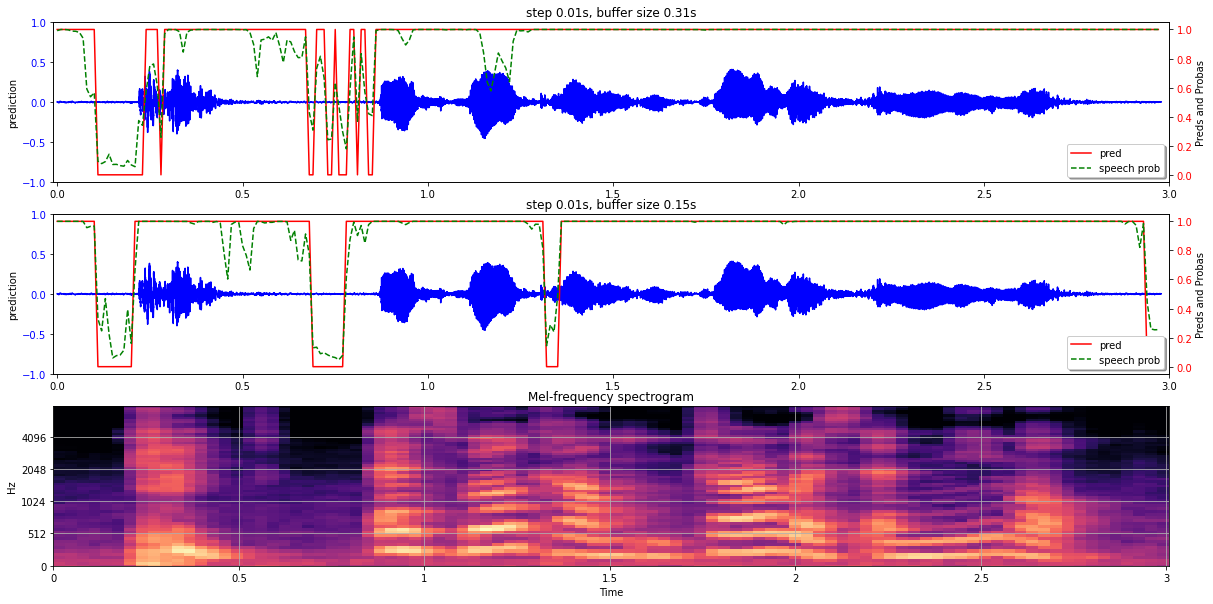

In [22]:
import librosa.display
plt.figure(figsize=[20,10])

num = len(results)
for i in range(num):
    len_pred = len(results[i][2]) 
    FRAME_LEN = results[i][0]
    ax1 = plt.subplot(num+1,1,i+1)

    ax1.plot(np.arange(audio.size) / sample_rate, audio, 'b')
    ax1.set_xlim([-0.01, int(dur)+1]) 
    ax1.tick_params(axis='y', labelcolor= 'b')
    ax1.set_ylabel('Signal')
    ax1.set_ylim([-1,  1])

    ax2 = ax1.twinx()
    ax2.plot(np.arange(len_pred)/(1/results[i][0]), np.array(results[i][2])  , 'r', label='pred')
    ax2.plot(np.arange(len_pred)/(1/results[i][0]), np.array(results[i][4]) ,  'g--', label='speech prob')
    ax2.tick_params(axis='y', labelcolor='r')
    legend = ax2.legend(loc='lower right', shadow=True)
    ax1.set_ylabel('prediction')

    ax2.set_title(f'step {results[i][0]}s, buffer size {results[i][1]}s')
    ax2.set_ylabel('Preds and Probas')
    
    
ax = plt.subplot(num+1,1,i+2)
S = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=64, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sample_rate, fmax=8000)
ax.set_title('Mel-frequency spectrogram')
ax.grid()
plt.show()

## Online inference through microphone

In [ ]:
STEP = 0.01 
WINDOW_SIZE = 0.31
CHANNELS = 1 
RATE = 16000
FRAME_LEN = STEP

CHUNK_SIZE = int(STEP * RATE)
vad = FrameVAD(model_definition = {
                   'sample_rate': SAMPLE_RATE,
                   'AudioToMFCCPreprocessor': cfg.preprocessor.params,
                   'JasperEncoder': cfg.encoder.params,
                   'labels': cfg.labels
               },
               frame_len=FRAME_LEN, frame_overlap=(WINDOW_SIZE - FRAME_LEN) / 2, 
               offset=0)


In [ ]:
vad.reset()

p = pa.PyAudio()
print('Available audio input devices:')
input_devices = []
for i in range(p.get_device_count()):
    dev = p.get_device_info_by_index(i)
    if dev.get('maxInputChannels'):
        input_devices.append(i)
        print(i, dev.get('name'))

if len(input_devices):
    dev_idx = -2
    while dev_idx not in input_devices:
        print('Please type input device ID:')
        dev_idx = int(input())

    empty_counter = 0

    def callback(in_data, frame_count, time_info, status):
        global empty_counter
        signal = np.frombuffer(in_data, dtype=np.int16)
        text = vad.transcribe(signal)
        if len(text):
            print(text,end='\n')
            empty_counter = vad.offset
        elif empty_counter > 0:
            empty_counter -= 1
            if empty_counter == 0:
                print(' ',end='\n')
        return (in_data, pa.paContinue)

    stream = p.open(format=pa.paInt16,
                    channels=CHANNELS,
                    rate=SAMPLE_RATE,
                    input=True,
                    input_device_index=dev_idx,
                    stream_callback=callback,
                    frames_per_buffer=CHUNK_SIZE)

    print('Listening...')

    stream.start_stream()
    
    # Interrupt kernel and then speak for a few more words to exit the pyaudio loop !
    try:
        while stream.is_active():
            time.sleep(0.1)
    finally:        
        stream.stop_stream()
        stream.close()
        p.terminate()

        print()
        print("PyAudio stopped")
    
else:
    print('ERROR: No audio input device found.')

## ONNX Deployment
You can also export the model to ONNX file and deploy it to TensorRT or MS ONNX Runtime inference engines.
To give it a try, just replace `infer_signal` implementation with this code:

In [ ]:
import onnxruntime
vad_model.export('vad.onnx')
ort_session = onnxruntime.InferenceSession('vad.onnx')

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

def infer_signal(signal):
    data_layer.set_signal(signal)
    batch = next(iter(data_loader))
    audio_signal, audio_signal_len = batch
    audio_signal, audio_signal_len = audio_signal.to(vad_model.device), audio_signal_len.to(vad_model.device)
    processed_signal, processed_signal_len = vad_model.preprocessor(
        input_signal=audio_signal, length=audio_signal_len,
    )
    ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(processed_signal), }
    ologits = ort_session.run(None, ort_inputs)
    alogits = np.asarray(ologits)
    logits = torch.from_numpy(alogits[0])
    return logits